In [36]:
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Base directory of the VOC dataset
base_dir = '/home/mahin/Downloads/Solar Panel Fault Detection Pascal VOC XML'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'valid')

# Function to parse the XML file and get the annotation data
def parse_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    boxes = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        xmlbox = obj.find('bndbox')
        bndbox = (int(xmlbox.find('xmin').text),
                  int(xmlbox.find('ymin').text),
                  int(xmlbox.find('xmax').text),
                  int(xmlbox.find('ymax').text))
        boxes.append((bndbox, class_name))
    return boxes


# Function to load dataset (images and labels)
def load_dataset(directory):
    images = []
    labels = []
    for img_filename in os.listdir(directory):
        if img_filename.endswith('.jpg'):
            img_path = os.path.join(directory, img_filename)
            annotation_path = img_path.replace('.jpg', '.xml')
            boxes = parse_annotation(annotation_path)

            image = cv2.imread(img_path)
            image = cv2.resize(image, (224, 224))
            images.append(image)

            # Assuming single object classification
            labels.append(boxes[0][1])  # Taking the first object's class label in the image
            
    return np.array(images), labels

# Load all datasets
train_images, train_labels = load_dataset(train_dir)
test_images, test_labels = load_dataset(test_dir)
val_images, val_labels = load_dataset(val_dir)

# Store label names for later use (do this before transforming labels to one-hot)
test_label_names = np.array(test_labels)  # Copy original label names
print("Unique labels in training data:", np.unique(train_labels))
print("Unique labels in test data:", np.unique(test_labels))
print("Label encoder classes:", label_encoder.classes_)

# Number of predicted and true labels
print("Number of predicted labels:", len(np.unique(predicted_labels)))
print("Number of true test labels:", len(np.unique(test_labels)))

# Convert labels to numerical values
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)
val_labels = label_encoder.transform(val_labels)

# Convert to one-hot encoding
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
val_labels = to_categorical(val_labels)



Unique labels in training data: ['BakimGereken' 'Cracked' 'Dirty' 'Good' 'Saglam']
Unique labels in test data: ['BakimGereken' 'Cracked' 'Dirty' 'Good' 'Saglam']
Label encoder classes: ['BakimGereken' 'Cracked' 'Dirty' 'Good' 'Saglam']
Number of predicted labels: 4
Number of true test labels: 5


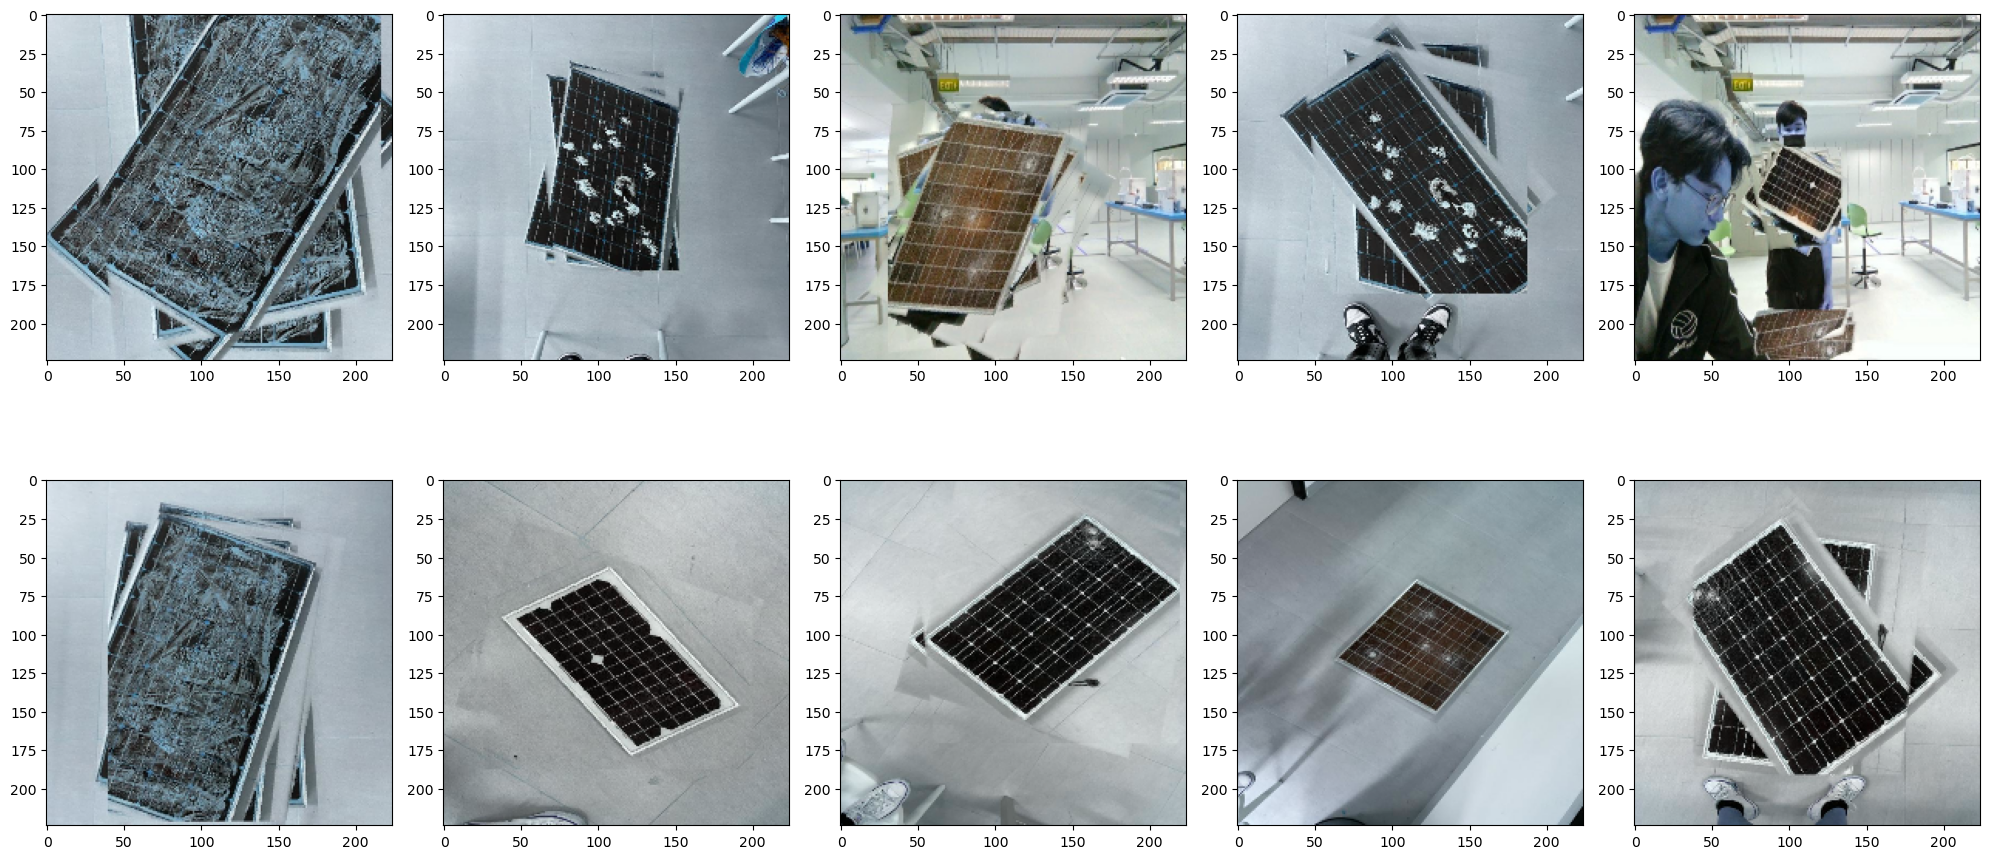

In [38]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Make sure you've run the dataset loading code before this

# Select 10 random indices
sample_indices = random.sample(range(len(train_images)), 10)

# Set up the matplotlib figure and axes
plt.figure(figsize=(20, 10))

for i, index in enumerate(sample_indices):
    # Load the image
    image = train_images[index]
    # Load the annotations
    annotations = train_labels[index]  # Assuming annotations are in the format (xmin, ymin, xmax, ymax, class_name)

    # Add subplot
    plt.subplot(2, 5, i+1)
    plt.imshow(image)

    

plt.tight_layout()
plt.show()


In [48]:

from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the VGG16 model
for layer in base_model.layers:
    layer.trainable = False

# Add new custom layers on top of VGG16
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output_layer = Dense(train_labels.shape[1], activation='softmax')(x)  # train_labels.shape[1] gives the number of classes

# Define the new model
model = Model(inputs=base_model.input, outputs=output_layer)

learning_rate = 0.0001

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Assuming that your data is already loaded and preprocessed
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
val_generator = val_datagen.flow(val_images, val_labels, batch_size=32)


# Fit the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=32)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test loss: {test_loss}, test accuracy: {test_accuracy}')

Epoch 1/10


/home/mahin/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 610ms/step - accuracy: 0.5104 - loss: 1.1082 - val_accuracy: 0.8659 - val_loss: 0.6290
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 615ms/step - accuracy: 0.8471 - loss: 0.4819 - val_accuracy: 0.9024 - val_loss: 0.3926
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 613ms/step - accuracy: 0.9201 - loss: 0.2871 - val_accuracy: 0.9146 - val_loss: 0.3545
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 621ms/step - accuracy: 0.9502 - loss: 0.2412 - val_accuracy: 0.9024 - val_loss: 0.2875
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 623ms/step - accuracy: 0.9473 - loss: 0.2082 - val_accuracy: 0.9268 - val_loss: 0.2329
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 619ms/step - accuracy: 0.9513 - loss: 0.1816 - val_accuracy: 0.9268 - val_loss: 0.2733
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 618ms/step - accuracy: 0.9417 - loss: 0.1784 - val_accuracy: 0.9390 - val_loss: 0.1901
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 627ms/step - accuracy: 0.9604 - loss: 0.1400 - val_accuracy: 0.939

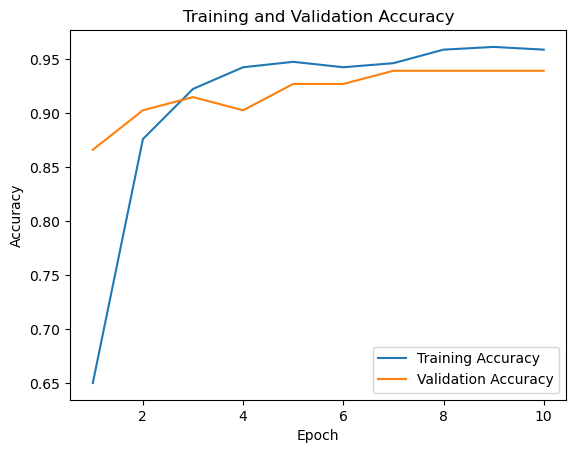

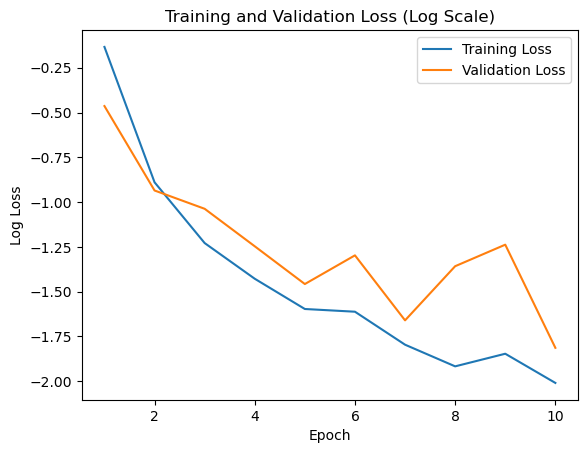

Best Validation Accuracy: 0.9390
Best Validation Loss: 0.1631


<Figure size 640x480 with 0 Axes>

In [49]:
# Plot the training and validation accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss using a logarithmic scale
plt.plot(range(1, len(train_loss) + 1), np.log(train_loss), label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), np.log(val_loss), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss (Log Scale)')
plt.legend()
plt.show()

# Save the accuracy plot as an image
plt.savefig('accuracy_plot.png', bbox_inches='tight')

# Calculate and display the best validation accuracy and loss
best_val_accuracy = max(val_accuracy)
best_val_loss = min(val_loss)
print(f'Best Validation Accuracy: {best_val_accuracy:.4f}')
print(f'Best Validation Loss: {best_val_loss:.4f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step
Classification Report:
ASDASD  ['Cracked' 'Good' 'Good' 'Good' 'Cracked' 'Cracked' 'Cracked' 'Cracked'
 'Saglam' 'Good' 'Good' 'Good' 'Good' 'Good' 'Cracked' 'Cracked' 'Cracked'
 'Cracked' 'BakimGereken' 'Cracked' 'Good' 'Good' 'Cracked' 'Good'
 'Cracked' 'Good' 'BakimGereken' 'Cracked' 'Good' 'BakimGereken' 'Cracked'
 'Good' 'Cracked' 'Cracked' 'Good' 'Cracked' 'Cracked' 'Cracked' 'Cracked'
 'Good' 'Good' 'BakimGereken' 'Dirty'] ['Good' 'Good' 'Good' 'Good' 'Cracked' 'Good' 'Cracked' 'Dirty' 'Cracked'
 'Saglam' 'Cracked' 'Good' 'Good' 'Cracked' 'Cracked' 'Good' 'Cracked'
 'BakimGereken' 'Cracked' 'Good' 'Cracked' 'Cracked' 'Good' 'Cracked'
 'Good' 'Cracked' 'BakimGereken' 'Cracked' 'Cracked' 'Good' 'BakimGereken'
 'Good' 'Cracked' 'Good' 'BakimGereken' 'Cracked' 'Good' 'Cracked'
 'Cracked' 'Good' 'Cracked' 'Cracked' 'Good'] ['BakimGereken', 'Dirty', 'Cracked', 'Good', 'Saglam']
Unique labels in true_labels: ['BakimGereken' 'Cracked' 'Dirty' 'Good

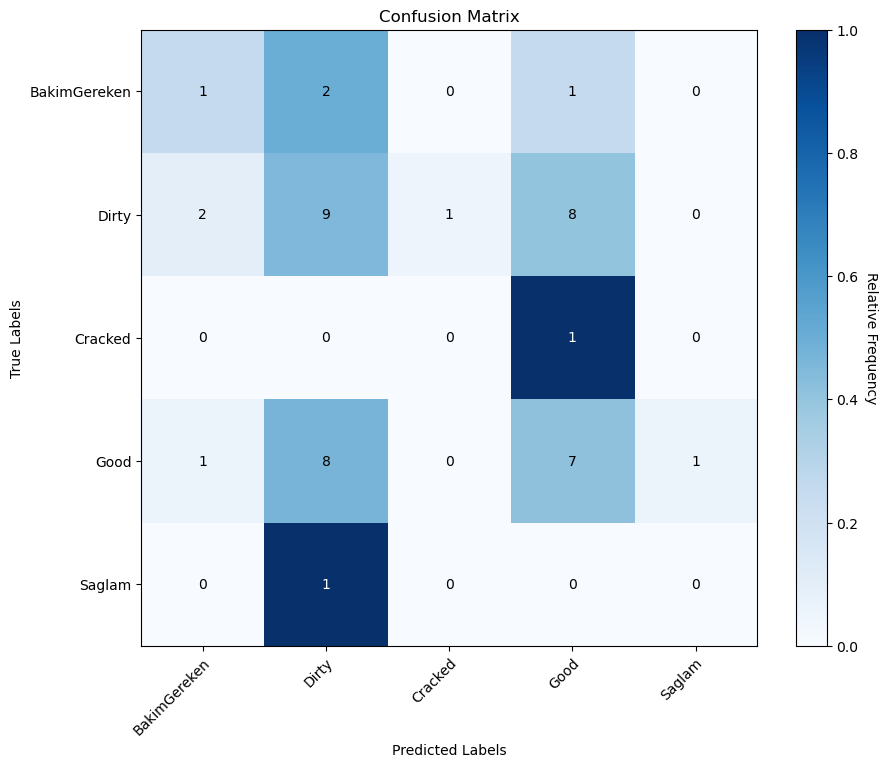

In [50]:
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

# Define the input shape and number of classes (Make sure to use the same values as in the training)

num_class = ['BakimGereken', 'Dirty', 'Cracked', 'Good', 'Saglam']
num_classes = 5

# Get the true labels for the test data
true_labels = test_label_names

# Get the predictions for the test data
predictions = model.predict(test_generator)
predicted_labels_encoded = np.argmax(predictions, axis=1)

# Convert encoded labels back to original names
predicted_labels = label_encoder.inverse_transform(predicted_labels_encoded)

# Calculate and print classification report
class_names =  ['BakimGereken', 'Dirty', 'Cracked', 'Good', 'Saglam']
print("Classification Report:")

print("ASDASD ", true_labels, predicted_labels, class_names)
print("Unique labels in true_labels:", np.unique(true_labels))
print("Unique labels in predicted_labels:", np.unique(predicted_labels))

print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Calculate and plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create an annotation array with the same shape as your confusion matrix
annot_array = np.array([['0' if item == 0 else str(item) for item in row] for row in cm])

# Create the confusion matrix plot manually
fig, ax = plt.subplots(figsize=(10, 8))

# Set the colormap
cmap = plt.cm.Blues

# Normalize the confusion matrix data
normed_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# This is the colormap I'd like to use.
cmap = sns.color_palette("Blues", as_cmap=True)

# Plot the heatmap
ax.imshow(normed_cm, interpolation='nearest', cmap=cmap)

# Add the color bar
cbar = ax.figure.colorbar(ax.imshow(normed_cm, interpolation='nearest', cmap=cmap), ax=ax)
cbar.ax.set_ylabel('Relative Frequency', rotation=-90, va="bottom")

# Add the text annotations.
thresh = normed_cm.max() / 1.5
for i in range(normed_cm.shape[0]):
    for j in range(normed_cm.shape[1]):
        ax.text(j, i, annot_array[i, j],
                ha="center", va="center",
                color="white" if normed_cm[i, j] > thresh else "black")

# Set the ticks and labels.
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Set labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

# Show the plot
plt.show()
